### In this notebook:
Decision Tree take as input:
- ERA5 values on the last day
- A subset of meteorological variables (Pressure, Relative Vorticity 850hPa,Wind Gust, Sea Surface Temperature 1000hPa, Wind Speed 850hPa, Air Density)
- Only values from the zone Z11

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
if os.getcwd() != '/content/drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset':
  os.chdir('./drive/MyDrive/Tropical_Cyclones_Thesis/ERA5_Dataset')

Mounted at /content/drive


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model

import pickle

 # Loading Datasets

In [3]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ERA5_16zones_avg_std_10D_NoWindDirection.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [4]:
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/ibtracs_Z11.csv')
df_target = df_target.drop(columns=['Unnamed: 0'])
df_target = df_target.set_index('DATE')
# df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['TC_PRESENCE']

df_target

DATE
1980-02-01    0
1980-02-02    1
1980-02-03    1
1980-02-04    0
1980-02-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: TC_PRESENCE, Length: 15310, dtype: int64

# Manually feature selection

Consider only Z11 variables to consistently reduce the number of variables

In [5]:
def is_exact_substring(main_string, substring):
    # Check if substring is in the main_string
    if substring in main_string:
        # Check if the substring is not followed by a digit
        index = main_string.find(substring)
        if index + len(substring) == len(main_string) or not main_string[index + len(substring)].isdigit():
            return True
    return False

def filter_features(df, feats):
  columns = df.columns
  selected_columns = []
  for col in columns:
    for feat in feats:
      if is_exact_substring(col, feat):
        selected_columns.append(col)
  return df[selected_columns]

selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_1000hPa', 'Wind_850hPa', 'Wind_300hPa', 'T_1000hPa', 'Air_Density']
#selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_850hPa', 'T_1000hPa', 'Air_Density']

selected_steps = ['-0']#, '-1', '-2', '-3']
selected_zones = ['_Z11']

print(8*4*6*2)

df_filtered = filter_features(df_era5, selected_meteo_feat)
df_filtered = filter_features(df_filtered, selected_steps)
df_filtered = filter_features(df_filtered, selected_zones)

cols = []
for elem in df_filtered.columns:
  elem = elem.replace('-0','')
  cols.append(elem.replace('_Z11',''))
df_filtered.columns = cols


from datetime import datetime

def day_of_year(date_string):
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    return date_object.timetuple().tm_yday

# Convert to list of day numbers
day_numbers = [day_of_year(date_str) for date_str in df_filtered.index]
df_filtered['yday'] = day_numbers

df_filtered

384


,P_Mean,P_Std,Vor_850hPa_Mean,Vor_850hPa_Std,Wind_Gust_Mean,Wind_Gust_Std,Wind_1000hPa_Mean,Wind_1000hPa_Std,Wind_850hPa_Mean,Wind_850hPa_Std,Wind_300hPa_Mean,Wind_300hPa_Std,T_1000hPa_Mean,T_1000hPa_Std,Air_Density_Mean,Air_Density_Std,yday
DATE,,,,,,,,,,,,,,,,,
1980-02-01,100839.731017,181.191942,-1.326374e-05,0.000030,9.161096,1.891302,8.030626,2.043022,8.482522,2.708363,5.320485,2.539159,298.471739,0.587952,1.160672,0.002807,32
1980-02-02,100819.805114,275.843829,-1.415175e-05,0.000042,13.511941,2.658089,10.984181,2.337932,13.300693,3.685055,9.385830,2.922391,298.590989,0.560706,1.159397,0.003655,33
1980-02-03,100624.544895,484.595148,-3.241318e-05,0.000063,14.583778,3.584316,12.698438,3.631855,15.776457,6.220648,9.869005,5.341686,298.370429,0.675645,1.158297,0.006810,34
1980-02-04,100803.244697,515.555038,-8.678676e-06,0.000079,13.257321,5.089852,10.006286,4.507314,11.668562,8.944703,9.528795,3.824716,298.688186,0.982700,1.158986,0.008253,35
1980-02-05,100982.396277,245.186655,5.546546e-06,0.000018,10.703720,3.427292,8.347398,2.595995,7.948358,5.141756,14.101187,3.314044,298.337832,0.897690,1.162109,0.005853,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101312.753918,37.618223,5.143506e-06,0.000021,4.121407,1.500981,2.490474,1.160273,2.725058,1.919368,9.128163,5.538250,298.534718,0.575989,1.164909,0.001809,361
2021-12-28,101220.225639,49.067544,-2.528924e-07,0.000024,4.851551,3.032916,3.386623,3.012908,2.221736,1.332991,13.674474,7.572192,298.337200,0.893729,1.165014,0.003450,362
2021-12-29,101050.137778,77.453997,-1.208212e-05,0.000062,8.444925,4.404138,5.737394,3.843089,4.733215,1.904213,14.903417,6.812252,297.744687,1.149675,1.165850,0.005070,363


# Tree-Based models for classification

In [6]:
X_train = df_filtered[df_filtered.index < '2012'].values
X_test = df_filtered[df_filtered.index > '2012'].values

y_train = df_target[df_target.index < '2012'].values
y_test = df_target[df_target.index > '2012'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('N Cyclones in train: ', np.count_nonzero(y_train))
print('N Cyclones in test:  ', np.count_nonzero(y_test))

(11657, 17) (11657,)
(3653, 17) (3653,)
N Cyclones in train:  532
N Cyclones in test:   169


# Decision Tree training

Decision Tree parameters

    criterion (default='gini' or 'entropy'):
        'gini': Gini impurity is used for the split criterion.
        'entropy': Information gain (using entropy) is used for the split criterion.

    splitter (default='best' or 'random'):
        'best': The best split is chosen based on the specified criterion.
        'random': A random split is chosen.

    max_depth (default=None):
        The maximum depth of the tree. Controls the maximum depth of the individual trees. Setting it to None means nodes are expanded until they contain less than min_samples_split samples.

    min_samples_split (default=2):
        The minimum number of samples required to split an internal node.

    min_samples_leaf (default=1):
        The minimum number of samples required to be at a leaf node.

    min_weight_fraction_leaf (default=0.0):
        The minimum weighted fraction of the sum total of weights (of all input samples) required to be at a leaf node.

    max_features (default=None):
        The number of features to consider when looking for the best split.
        'auto': All features are considered.
        'sqrt': The square root of the total number of features is considered.
        'log2': The base-2 logarithm of the total number of features is considered.
        None: All features are considered.

    max_leaf_nodes (default=None):
        Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.

    min_impurity_decrease (default=0.0):
        A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

    class_weight (default=None):
        Weights associated with classes in the form {class_label: weight}.
        If not given, all classes have weight one.

    random_state (default=None):
        Controls the randomness of the estimator.

In [7]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
import time

# Record the start time
start_time = time.time()

# Best hyperparameters:
# max_depth = 5
# criterion = 'gini'
# split = 'best'

# MAX_DEPTH --------->  5
# Accuracy    : 0.98
# F1 Score    : 0.72
# Recall      : 0.66
# N TC        : 169
# TC predicted: 139
# FAR         : 0.20

clf = DecisionTreeClassifier(
                            max_depth = 5,                    #(default=None):
                            criterion = 'gini',               #(default='gini' or 'entropy'):
                            splitter  = 'best',               #(default='best' or 'random'):
                            min_samples_split = 2,            #(default=2):
                            min_samples_leaf = 1,             #(default=1):
                            min_weight_fraction_leaf=0.0,     #(default=0.0):
                            max_features=None,                #(default=None):
                            max_leaf_nodes=None,              #(default=None):
                            min_impurity_decrease=0.0,        #(default=0.0):
                            class_weight=None, #{0: 0.9, 1: 2},      #(default=None):
                            random_state=None                 #(default=None):
                            )
clf = clf.fit(X_train, y_train)

# Record the end time
end_time = time.time()
# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Evaluate the model
y_pred   = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'
recall   = recall_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'

# Print the evaluation metrics
print(f"Accuracy    : {accuracy:.2f}")
print(f"F1 Score    : {f1:.2f}")
print(f"Recall      : {recall:.2f}")

N_test = len(y_test)
fp = 0
n_cyclones_predicted = np.count_nonzero(y_pred)
n_cyclones = np.count_nonzero(y_test)

for i in range(N_test):
  if y_test[i] == 0 and y_pred[i] == 1:
    fp += 1

far = fp/n_cyclones_predicted
print(f"N TC        : {n_cyclones}")
print(f"TC predicted: {n_cyclones_predicted}")
print(f"FAR         : {far:.2f}")
print('--------------------------------------------------------')

Training time: 0.13793349266052246 seconds
Accuracy    : 0.98
F1 Score    : 0.72
Recall      : 0.66
N TC        : 169
TC predicted: 138
FAR         : 0.20
--------------------------------------------------------


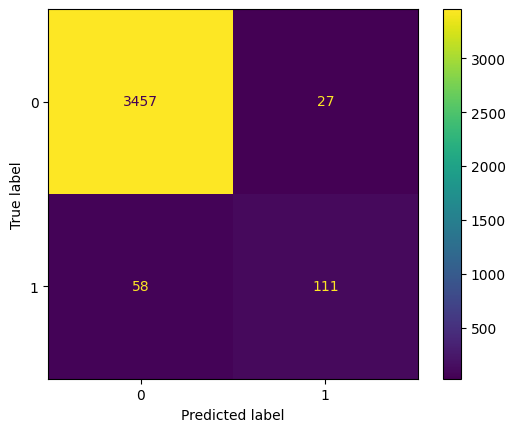

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_, )
disp.plot()
plt.show()

## Plot tree

In [9]:
import pydotplus
from sklearn import tree
from IPython.display import Image, display

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_filtered.columns,
                                class_names=['Negative', 'Positive'],
                                filled=True, rounded=True, node_ids=True,
                                special_characters=True, precision=10)
graph = pydotplus.graph_from_dot_data(dot_data)

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('gini = ') or label.startswith('value = '):
              labels.pop(i)
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

arr = ['7', '12', '16', '20', '23', '32', '39', '44', '47', '50', '53']

for n in graph.get_nodes():
    # n.set('style', 'filled')
    # n.set('fillcolor', 'aliceblue')
    n.set('fontsize', '50')
    # n.set('fontname', 'Trebuhet MS, Tahoma, Verdana, Arial, Helvetica, sans-serif')
    # print(n.get_label())
    #print(n.get_name())
    if 'Positive' in str(n.get_label()) and n.get_name() in arr:
      n.set('fillcolor', 'green')

for e in graph.get_edges():
    e.set_minlen(10)

filename = 'tree.png'
# graph.set_fontsize()
# graph.set_size('",30!"')
graph.write_png(filename)
# Display the graph in the notebook
display(Image(filename=filename))

In [10]:
y_pred = clf.predict(X_test)
tp_test = 0
assert len(y_pred) == len(y_test)
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_test[i] == 1:
    tp_test += 1

y_pred = clf.predict(X_train)
tp_train = 0
assert len(y_pred) == len(y_train)
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_train[i] == 1:
    tp_train += 1


print('Number of positive exaples in training set: ', np.count_nonzero(y_train))
print('Number of true positives in the training set: ', tp_train)
print('Number of true positives in the test set: ', tp_test)

Number of positive exaples in training set:  532
Number of true positives in the training set:  346
Number of true positives in the test set:  111


In [11]:
# Evaluate the model
y_pred   = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
f1       = f1_score(y_train, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'
recall   = recall_score(y_train, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'

# Print the evaluation metrics
print(f"Accuracy    : {accuracy:.2f}")
print(f"F1 Score    : {f1:.2f}")
print(f"Recall      : {recall:.2f}")

N_test = len(y_train)
fp = 0
n_cyclones_predicted = np.count_nonzero(y_pred)
n_cyclones = np.count_nonzero(y_train)

for i in range(N_test):
  if y_train[i] == 0 and y_pred[i] == 1:
    fp += 1

far = fp/n_cyclones_predicted
print(f"N TC        : {n_cyclones}")
print(f"TC predicted: {n_cyclones_predicted}")
print(f"FAR         : {far:.2f}")
print('--------------------------------------------------------')

Accuracy    : 0.98
F1 Score    : 0.75
Recall      : 0.65
N TC        : 532
TC predicted: 392
FAR         : 0.12
--------------------------------------------------------


In [12]:
from sklearn.tree import DecisionTreeClassifier, export_text
tree_rules = export_text(clf, feature_names=list(df_filtered.columns) ,decimals=10)
print(tree_rules)

|--- Vor_850hPa_Mean <= -0.0000131857
|   |--- Vor_850hPa_Std <= 0.0000374302
|   |   |--- yday <= 60.0000000000
|   |   |   |--- Wind_1000hPa_Mean <= 7.0005607605
|   |   |   |   |--- class: 0
|   |   |   |--- Wind_1000hPa_Mean >  7.0005607605
|   |   |   |   |--- Air_Density_Std <= 0.0031330852
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Air_Density_Std >  0.0031330852
|   |   |   |   |   |--- class: 1
|   |   |--- yday >  60.0000000000
|   |   |   |--- yday <= 320.5000000000
|   |   |   |   |--- class: 0
|   |   |   |--- yday >  320.5000000000
|   |   |   |   |--- T_1000hPa_Std <= 0.9198407829
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- T_1000hPa_Std >  0.9198407829
|   |   |   |   |   |--- class: 1
|   |--- Vor_850hPa_Std >  0.0000374302
|   |   |--- Wind_300hPa_Std <= 7.5408978462
|   |   |   |--- P_Std <= 196.7230377197
|   |   |   |   |--- Wind_1000hPa_Mean <= 9.5890274048
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Wind_1000hPa_Mean >  9.5890274

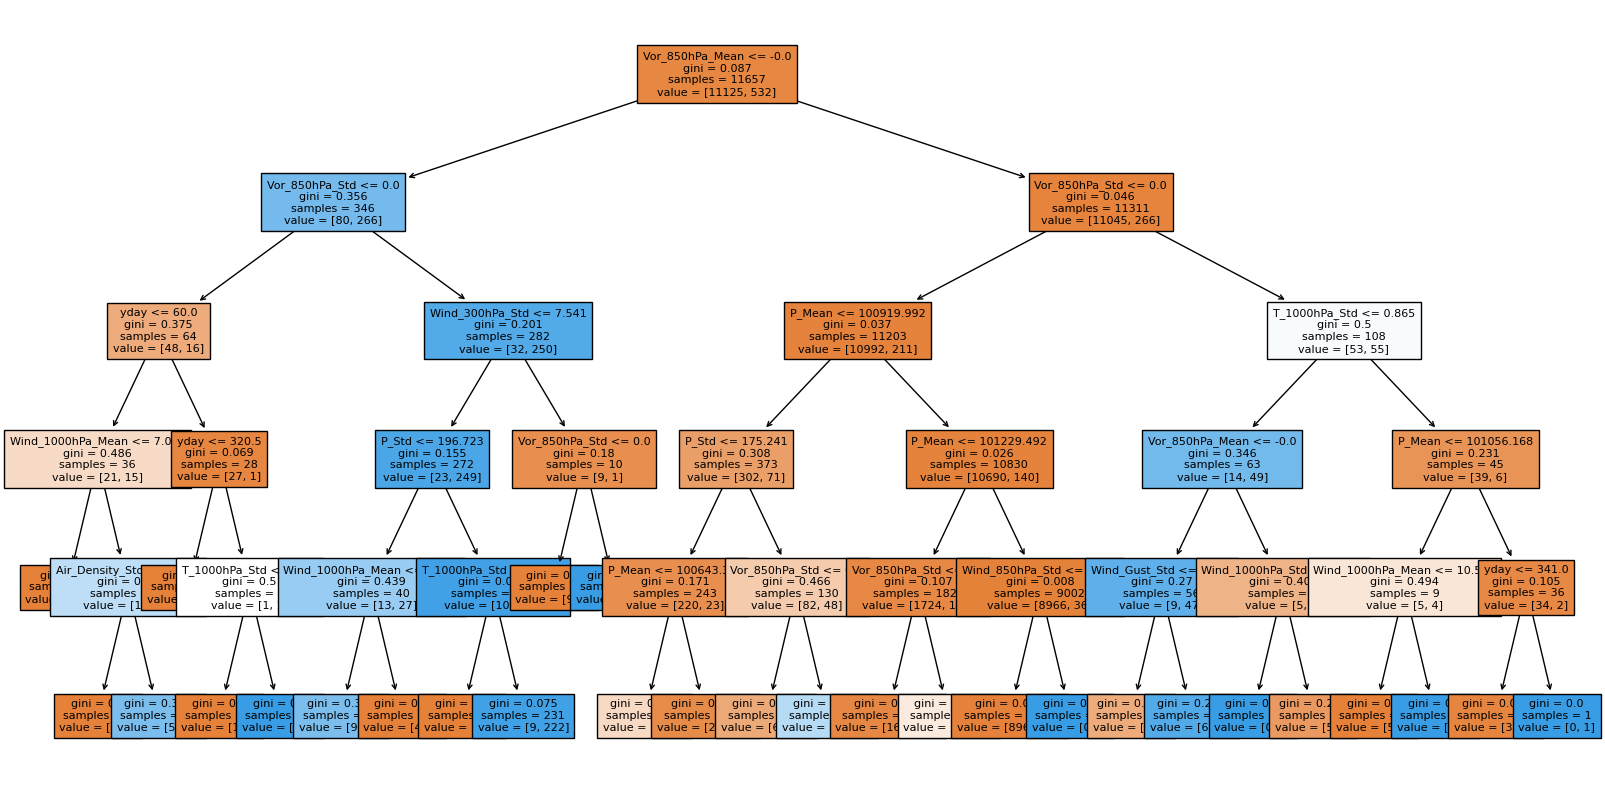

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Replace features_list with your list of feature names
features_list = df_filtered.columns

# Plot the decision tree with specified feature names
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=features_list, fontsize=8)
plt.show()

In [14]:
import random
idx = random.randint(0, X_test.shape[0]-1)
samples = X_test[idx]
target = y_test[idx]
pred = clf.predict(samples.reshape(1,-1))[0]
decision_paths = clf.decision_path(samples.reshape(1,-1))


print('SAMPLE IDX: ', idx)
print('TARGET:     ', target)
print('PREDICTED:  ', pred)

if target == pred == 1:
  print('TRUE POSITIVE')
elif target == pred == 0:
  print('TRUE NEGATIVE')

SAMPLE IDX:  457
TARGET:      0
PREDICTED:   0
TRUE NEGATIVE


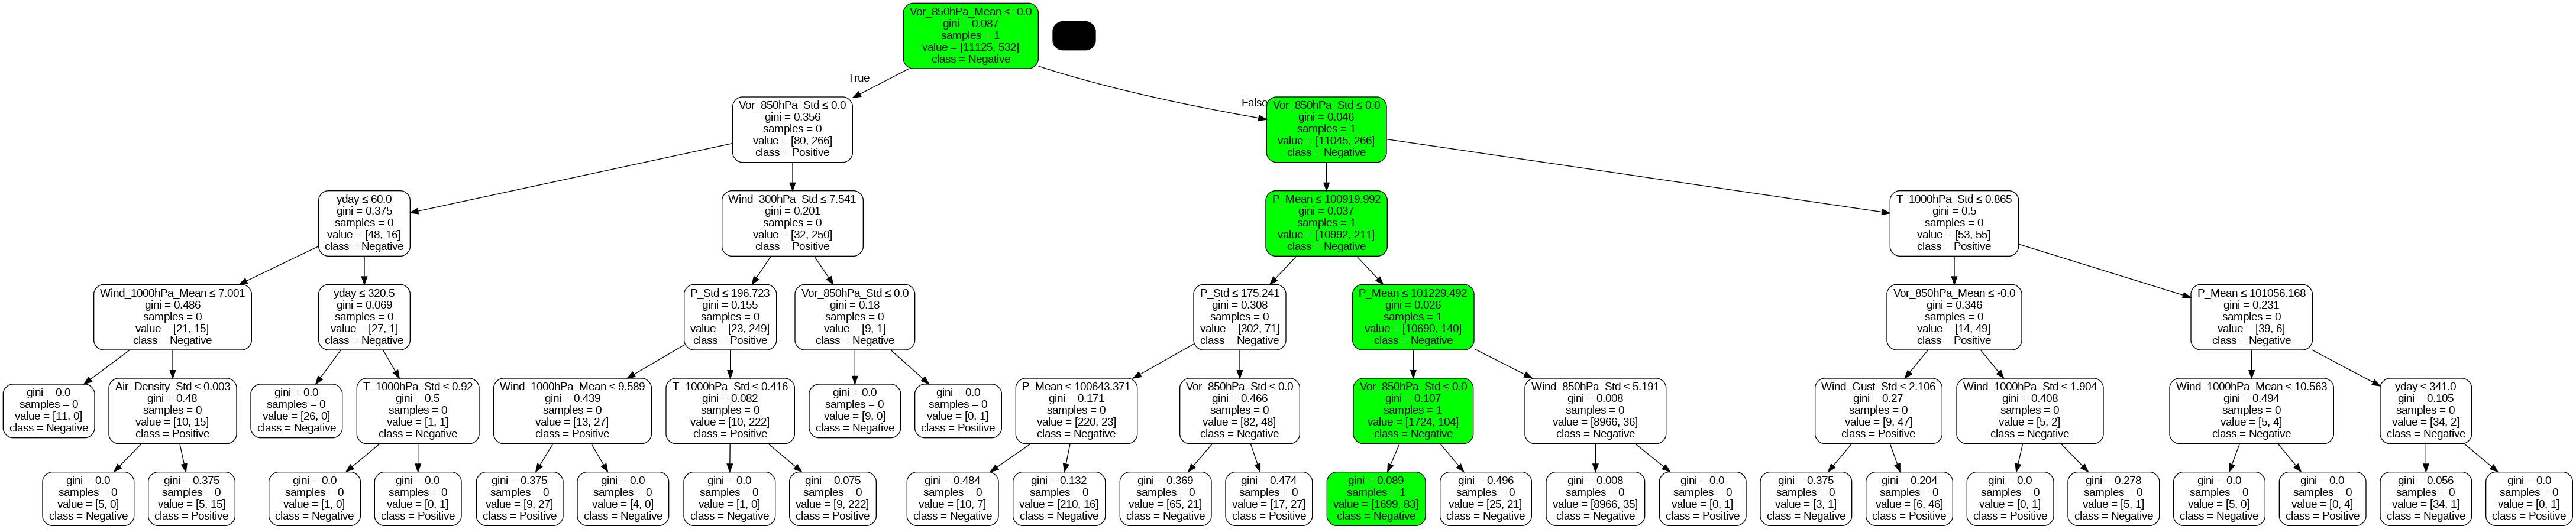

In [15]:
import pydotplus
import random
from sklearn import tree
from IPython.display import Image, display

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_filtered.columns,
                                class_names=['Negative', 'Positive'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        green_light = True
        node = graph.get_node(str(n))[0]
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
        node.set('label', '<br/>'.join(labels))


filename = 'tree.png'
graph.write_png(filename)
# Display the graph in the notebook
display(Image(filename=filename))

SAMPLE IDX:  457
TARGET:      0
PREDICTED:   [0]
[(<pydotplus.graphviz.Node object at 0x7a766a9933a0>, <pydotplus.graphviz.Node object at 0x7a766a993280>), (<pydotplus.graphviz.Node object at 0x7a766a993280>, <pydotplus.graphviz.Node object at 0x7a766a9931c0>), (<pydotplus.graphviz.Node object at 0x7a766a9931c0>, <pydotplus.graphviz.Node object at 0x7a766a993490>), (<pydotplus.graphviz.Node object at 0x7a766a993490>, <pydotplus.graphviz.Node object at 0x7a766a9934f0>), (<pydotplus.graphviz.Node object at 0x7a766a9934f0>, <pydotplus.graphviz.Node object at 0x7a766a993d60>)]


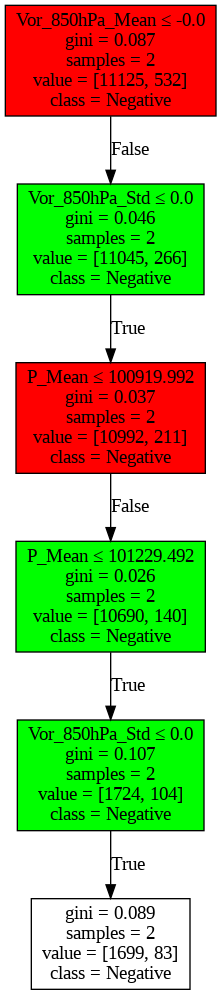

In [16]:
# idx = random.randint(0, X_test.shape[0]-1)
samples = X_test[idx]
target = y_test[idx]
decision_paths = clf.decision_path(samples.reshape(1,-1))

print('SAMPLE IDX: ', idx)
print('TARGET:     ', target)
print('PREDICTED:  ', clf.predict(samples.reshape(1,-1)))

prediction_nodes = []
decisions = []
prev_node_idx = 0
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue

        if n == prev_node_idx + 1:
          decisions.append(True)
        else:
          decisions.append(False)
        prev_node_idx = n

        node = graph.get_node(str(n))[0]
        prediction_nodes.append(node)
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
        node.set('label', '<br/>'.join(labels))

# Create a Dot object representing the graph
graph_path = pydotplus.Dot(graph_type='digraph')

# Add nodes to the graph
for node in prediction_nodes:
    node.set_shape('box')
    node.set_style('filled')
    node.set_color('black')
    node.set_fillcolor('white')
    graph_path.add_node(node)

# # Example edges (you may need to specify edges based on your use case)
edges = []
for i in range(len(prediction_nodes)-1):
  edges.append((prediction_nodes[i], prediction_nodes[i+1]))
print(edges)
# # Add edges to the graph
j = 1
for edge in edges:
    if decisions[j]:
      edge[0].set_fillcolor('green')
      graph_path.add_edge(pydotplus.Edge(edge[0], edge[1], label='True'))
    else:
      edge[0].set_fillcolor('red')
      graph_path.add_edge(pydotplus.Edge(edge[0], edge[1], label='False'))
    j +=1

# Save the graph as a PNG file
graph_file = 'example_graph.png'
graph_path.write_png(graph_file)

# Display the graph in the notebook
display(Image(filename=graph_file))

# Analyze all the rules to classify a tropical cyclone

Consider all the path to reach a tropical cyclone prediction


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 10)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 10)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules

rules = get_rules(clf, df_filtered.columns, ['Neg', 'Pos'])
positive_rules = []
for r in rules:
  if 'then class: Pos' in r:
    positive_rules.append(r)
    print(r)

if (Vor_850hPa_Mean <= -1.31857e-05) and (Vor_850hPa_Std > 3.74302e-05) and (Wind_300hPa_Std <= 7.5408978462) and (P_Std > 196.7230377197) and (T_1000hPa_Std > 0.4158065617) then class: Pos (proba: 96.1%) | based on 231 samples
if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std > 4.79227e-05) and (T_1000hPa_Std <= 0.8649717867) and (Vor_850hPa_Mean <= -3.1055e-06) and (Wind_Gust_Std > 2.106030345) then class: Pos (proba: 88.46%) | based on 52 samples
if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std <= 4.79227e-05) and (P_Mean <= 100919.9921875) and (P_Std > 175.2408065796) and (Vor_850hPa_Std > 3.26144e-05) then class: Pos (proba: 61.36%) | based on 44 samples
if (Vor_850hPa_Mean <= -1.31857e-05) and (Vor_850hPa_Std > 3.74302e-05) and (Wind_300hPa_Std <= 7.5408978462) and (P_Std <= 196.7230377197) and (Wind_1000hPa_Mean <= 9.5890274048) then class: Pos (proba: 75.0%) | based on 36 samples
if (Vor_850hPa_Mean <= -1.31857e-05) and (Vor_850hPa_Std <= 3.74302e-05) and (yday <= 

In [18]:
# Plot how the dataset is separated
rules = get_rules(clf, df_filtered.columns, ['Neg', 'Pos'])
all_paths = []
for r in rules:
  all_paths.append(r)

for path in all_paths:
  print(path)

if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std <= 4.79227e-05) and (P_Mean > 100919.9921875) and (P_Mean > 101229.4921875) and (Wind_850hPa_Std <= 5.1909511089) then class: Neg (proba: 99.61%) | based on 9,001 samples
if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std <= 4.79227e-05) and (P_Mean > 100919.9921875) and (P_Mean <= 101229.4921875) and (Vor_850hPa_Std <= 4.04935e-05) then class: Neg (proba: 95.34%) | based on 1,782 samples
if (Vor_850hPa_Mean <= -1.31857e-05) and (Vor_850hPa_Std > 3.74302e-05) and (Wind_300hPa_Std <= 7.5408978462) and (P_Std > 196.7230377197) and (T_1000hPa_Std > 0.4158065617) then class: Pos (proba: 96.1%) | based on 231 samples
if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std <= 4.79227e-05) and (P_Mean <= 100919.9921875) and (P_Std <= 175.2408065796) and (P_Mean > 100643.37109375) then class: Neg (proba: 92.92%) | based on 226 samples
if (Vor_850hPa_Mean > -1.31857e-05) and (Vor_850hPa_Std <= 4.79227e-05) and (P_Mean <= 100919.992187

In [19]:
import re

rules_dict = {}

for path in all_paths:
  # print(path)
  input_string = path
  # Extracting rules inside round brackets using regular expression
  rules_inside_brackets = re.findall(r'\(([^)]+)\)', input_string)
  for rule in rules_inside_brackets:
    if not 'proba' in rule:
      # print(rule)
      rules_dict[rule] = rules_dict.get(rule, 0) + 1
  # print('-----------------------')

for r in rules_dict:
  print(r)

Vor_850hPa_Mean > -1.31857e-05
Vor_850hPa_Std <= 4.79227e-05
P_Mean > 100919.9921875
P_Mean > 101229.4921875
Wind_850hPa_Std <= 5.1909511089
P_Mean <= 101229.4921875
Vor_850hPa_Std <= 4.04935e-05
Vor_850hPa_Mean <= -1.31857e-05
Vor_850hPa_Std > 3.74302e-05
Wind_300hPa_Std <= 7.5408978462
P_Std > 196.7230377197
T_1000hPa_Std > 0.4158065617
P_Mean <= 100919.9921875
P_Std <= 175.2408065796
P_Mean > 100643.37109375
P_Std > 175.2408065796
Vor_850hPa_Std <= 3.26144e-05
Vor_850hPa_Std > 4.79227e-05
T_1000hPa_Std <= 0.8649717867
Vor_850hPa_Mean <= -3.1055e-06
Wind_Gust_Std > 2.106030345
Vor_850hPa_Std > 4.04935e-05
Vor_850hPa_Std > 3.26144e-05
P_Std <= 196.7230377197
Wind_1000hPa_Mean <= 9.5890274048
T_1000hPa_Std > 0.8649717867
P_Mean > 101056.16796875
yday <= 341.0
Vor_850hPa_Std <= 3.74302e-05
yday > 60.0
yday <= 320.5
yday <= 60.0
Wind_1000hPa_Mean > 7.0005607605
Air_Density_Std > 0.0031330852
P_Mean <= 100643.37109375
Wind_1000hPa_Mean <= 7.0005607605
Wind_300hPa_Std > 7.5408978462
Vor_85

# Evaluate predictions with different time-horizon

In [20]:
X_train.shape, y_train.shape

((11657, 17), (11657,))

In [21]:
X_train_future = []
y_train_future = []
X_test_future = []
y_test_future = []


for i in range(10):
  X_train_future.append(X_train[:len(X_train)-i])
  y_train_future.append(y_train[i:])
  X_test_future.append(X_test[:len(X_test)-i])
  y_test_future.append(y_test[i:])

In [22]:
from sklearn.metrics import precision_score

accuracies = []
precisions = []
fars = []
recalls = []
models = []
f1s = []

for i in range(10):
  # Record the start time
  start_time = time.time()
  # Best hyperparameters:
  # max_depth = 5
  # criterion = 'gini'
  # split = 'best'

  # MAX_DEPTH --------->  5
  clf = DecisionTreeClassifier(
                              max_depth = 5,                    #(default=None):
                              criterion = 'gini',               #(default='gini' or 'entropy'):
                              splitter  = 'best',               #(default='best' or 'random'):
                              min_samples_split = 2,            #(default=2):
                              min_samples_leaf = 1,             #(default=1):
                              min_weight_fraction_leaf=0.0,     #(default=0.0):
                              max_features=None,                #(default=None):
                              max_leaf_nodes=None,              #(default=None):
                              min_impurity_decrease=0.0,        #(default=0.0):
                              class_weight=None, #{0: 0.9, 1: 2},      #(default=None):
                              random_state=None                 #(default=None):
                              )
  clf = clf.fit(X_train_future[i], y_train_future[i])

  models.append(clf)

  # Record the end time
  end_time = time.time()
  # Calculate and print the training time
  training_time = end_time - start_time
  print(f"Training time: {training_time} seconds")

  # Evaluate the model
  y_pred   = clf.predict(X_test_future[i])
  accuracy = accuracy_score(y_test_future[i], y_pred)
  precision = precision_score(y_test_future[i], y_pred)
  f1       = f1_score(y_test_future[i], y_pred)  # Specify 'micro', 'macro', 'weighted', or 'binary'
  recall   = recall_score(y_test_future[i], y_pred)  # Specify 'micro', 'macro', 'weighted', or 'binary'

  # Print the evaluation metrics
  print(f"Accuracy    : {accuracy:.2f}")
  print(f"F1 Score    : {f1:.2f}")
  print(f"Recall      : {recall:.2f}")
  print(f"Precision   : {precision:.2f}")


  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  fars.append(far)
  f1s.append(f1)

  N_test = len(y_test_future[i])
  fp = 0
  n_cyclones_predicted = np.count_nonzero(y_pred)
  n_cyclones = np.count_nonzero(y_test_future[i])

  for j in range(N_test):
    if y_test_future[i][j] == 0 and y_pred[j] == 1:
      fp += 1

  far = fp/n_cyclones_predicted
  print(f"N TC        : {n_cyclones}")
  print(f"TC predicted: {n_cyclones_predicted}")
  print(f"FAR         : {far:.2f}")
  print('--------------------------------------------------------')

Training time: 0.1397261619567871 seconds
Accuracy    : 0.98
F1 Score    : 0.72
Recall      : 0.65
Precision   : 0.80
N TC        : 169
TC predicted: 137
FAR         : 0.20
--------------------------------------------------------
Training time: 0.13705110549926758 seconds
Accuracy    : 0.96
F1 Score    : 0.40
Recall      : 0.30
Precision   : 0.59
N TC        : 168
TC predicted: 85
FAR         : 0.41
--------------------------------------------------------
Training time: 0.13652992248535156 seconds
Accuracy    : 0.95
F1 Score    : 0.03
Recall      : 0.02
Precision   : 0.16
N TC        : 167
TC predicted: 19
FAR         : 0.84
--------------------------------------------------------
Training time: 0.14319634437561035 seconds
Accuracy    : 0.95
F1 Score    : 0.12
Recall      : 0.08
Precision   : 0.24
N TC        : 166
TC predicted: 54
FAR         : 0.76
--------------------------------------------------------
Training time: 0.13567686080932617 seconds
Accuracy    : 0.95
F1 Score    : 0.01

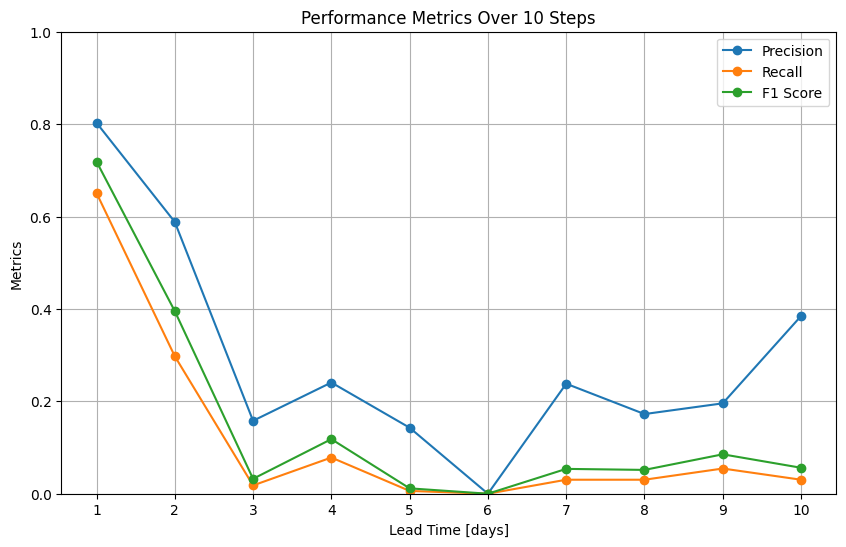

In [23]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
steps = range(1, 11)

# Plotting
plt.figure(figsize=(10, 6))

# plt.plot(steps, accuracies, label='Accuracy', marker='o')
plt.plot(steps, precisions, label='Precision', marker='o')
# plt.plot(steps, fars, label='False Alarm Rate', marker='o')
plt.plot(steps, recalls, label='Recall', marker='o')
plt.plot(steps, f1s, label='F1 Score', marker='o')

plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Performance Metrics Over 10 Steps')
plt.legend()
plt.grid(True)
plt.xticks(steps)
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
plt.show()

# Compare results with XGBoost on Z11

In [24]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.7 MB/s eta 0:00:00


In [25]:
import optuna
import sklearn.metrics
import xgboost as xgb

# HPO with Optuna (HyperParameters Optimization)
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "device": "cuda",
        # scale_pos_weight – Balancing of positive and negative weights.
        # 'scale_pos_weight': neg_pos_ratio,
        "random_state": 42,

        # use exact for small dataset.
        "tree_method": "hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        #"booster": "dart",
        # L2 regularization weight.
        #"reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        #"reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        #"subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # learning rate
        #"eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "eta": 0.1,
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),

        # n_estimators
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        # max_depth
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        # max_leaves
        "max_leaves": trial.suggest_int("max_leaves", 5, 300),

        # max_bin
        # grow_policy
        #"grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        # min_child_weight
        # max_delta_step
    }

    xgb_classifier = xgb.XGBRFClassifier(**param)
    xgb_classifier.fit(X_train, y_train)
    pred = xgb_classifier.predict(X_test).transpose()
    accuracy = sklearn.metrics.accuracy_score(y_test, pred)
    recall = sklearn.metrics.recall_score(y_test, pred)
    f1 = sklearn.metrics.f1_score(y_test, pred)

    return f1

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=2000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-18 12:09:59,346] A new study created in memory with name: no-name-38475b6e-a40c-4e4c-b547-958fdf9cf45a
[I 2024-04-18 12:10:00,623] Trial 0 finished with value: 0.763076923076923 and parameters: {'booster': 'dart', 'colsample_bytree': 0.6433706761283398, 'gamma': 1.616079057460868e-06, 'n_estimators': 32, 'max_depth': 127, 'max_leaves': 95}. Best is trial 0 with value: 0.763076923076923.
[I 2024-04-18 12:10:25,690] Trial 1 finished with value: 0.7692307692307693 and parameters: {'booster': 'dart', 'colsample_bytree': 0.5008983954411299, 'gamma': 2.600889929728275e-08, 'n_estimators': 769, 'max_depth': 18, 'max_leaves': 214}. Best is trial 1 with value: 0.7692307692307693.
[I 2024-04-18 12:10:43,685] Trial 2 finished with value: 0.77602523659306 and parameters: {'booster': 'dart', 'colsample_bytree': 0.2856909418014943, 'gamma': 0.0007663844978548412, 'n_estimators': 503, 'max_depth': 292, 'max_leaves': 97}. Best is trial 2 with value: 0.77602523659306.
[I 2024-04-18 12:10:47,

Number of finished trials:  15
Best trial:
  Value: 0.778816199376947
  Params: 
    booster: dart
    colsample_bytree: 0.37961277999429693
    gamma: 0.005105133388104825
    n_estimators: 328
    max_depth: 298
    max_leaves: 299


In [27]:
import time

param = trial.params
print(param)
models = []

start = time.time()
print('Training model to predict TC at time t+{} ...'.format(i+1))
xgb_classifier = xgb.XGBRFClassifier(**param)
xgb_classifier.fit(X_train, y_train)
models.append(xgb_classifier)
end = time.time()
print('Training phase completed')
print('Training duration: {}'.format(round((end-start))/60))
print('-----------------------------------------------')

{'booster': 'dart', 'colsample_bytree': 0.37961277999429693, 'gamma': 0.005105133388104825, 'n_estimators': 328, 'max_depth': 298, 'max_leaves': 299}
Training model to predict TC at time t+10 ...
Training phase completed
Training duration: 0.05
-----------------------------------------------


In [28]:
# Evaluate the model
y_pred   = xgb_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
f1       = f1_score(y_train, y_pred)  # Specify 'micro', 'macro', 'weighted', or 'binary'
precision = precision_score(y_train, y_pred)
recall   = recall_score(y_train, y_pred)  # Specify 'micro', 'macro', 'weighted', or 'binary'

# Print the evaluation metrics
print(f"Accuracy    : {accuracy:.2f}")
print(f"F1 Score    : {f1:.2f}")
print(f"Recall      : {recall:.2f}")
print(f"Precision   : {precision:.2f}")

N_test = len(y_train)
fp = 0
n_cyclones_predicted = np.count_nonzero(y_pred)
n_cyclones = np.count_nonzero(y_train)

for i in range(N_test):
  if y_train[i] == 0 and y_pred[i] == 1:
    fp += 1

far = fp/n_cyclones_predicted
print(f"N TC        : {n_cyclones}")
print(f"TC predicted: {n_cyclones_predicted}")
print(f"FAR         : {far:.2f}")
print('--------------------------------------------------------')

Accuracy    : 0.99
F1 Score    : 0.84
Recall      : 0.80
Precision   : 0.87
N TC        : 532
TC predicted: 491
FAR         : 0.13
--------------------------------------------------------
